In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/MLDL/semi-inat-2021.zip /
!unzip -qq /semi-inat-2021.zip 

In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np
import random
l_train_path = './l_train'
u_train_path = './u_train'
val_path = './val'
test_path = './test'
classes = 810
max_width = 300
max_length = 300

input_size = 224

## Image Transforms

##following are required 
# this one is to convert to pytorch format 
to_pytorch_tensor = transforms.Compose([
        transforms.PILToTensor(),
        
])

# some images are not 3 channels
to_3channels = transforms.Compose([
        transforms.Lambda(lambda x: x.repeat(3,1,1))
        ])
    
#for l_train and val
#there are 810 folders from 0 to 809
#will return image and label
#if use the default transfrom, image will be a pytorch tensor
#pass use_memory = False, if ran out of ram
class iNat_dataset_labeled(Dataset):
    def __init__(self, 
                 data_type, 
                 tf = None):
      self.data_type = data_type
      if self.data_type == 'l_train':
        self.data_dir = os.path.join(l_train_path, 'l_train')
      elif self.data_type == 'val':
        self.data_dir = os.path.join(val_path, 'val')
      #if load all data into memeory
      self.transform = tf
      self.data = []
      self.labels = []
      for i in range(classes):
        path = os.path.join(self.data_dir, str(i))
        images = os.listdir(path)
        for j in range(len(images)):
          img = os.path.join(path, images[j])
          img = Image.open(img)
          self.data.append(img)
          self.labels.append(i)

    def __len__(self):
      return len(self.labels)

    def __getitem__(self, idx):
      img = self.data[idx]
      img = to_pytorch_tensor(img)
      if img.size(0) != 3:
        img = to_3channels(img)
      if self.transform:
        img = self.transform(img)
      
      return img, self.labels[idx]

#for u_train and test
#return image and its file name 
class iNat_dataset_unlabeled(Dataset):
    def __init__(self, 
                 data_type, 
                 tf = None):
      self.data_type = data_type
      if self.data_type == 'u_train':
        self.data_dir = os.path.join(u_train_path, 'u_train')
      elif self.data_type == 'test':
        self.data_dir = os.path.join(test_path, 'test')

      self.transform = tf
      self.data = []
      self.names = []

      images = os.listdir(self.data_dir)
      for i in range(len(images)):
        path = os.path.join(self.data_dir, images[i])
        self.data.append(path)
        self.names.append(images[i])

    def __len__(self):
      return len(self.names)

    def __getitem__(self, idx):
      img = Image.open(self.data[idx])
      img = to_pytorch_tensor(img)

      if img.size(0) != 3:
        if img.size(0) == 1:
          img = to_3channels(img)
        else:
          idx = 0
          path = os.path.join(u_train_path, 'u_train', self.names[idx])
          img = Image.open(path)
          img = to_pytorch_tensor(img)

      if self.transform:
        img = self.transform(img)
      
      return img

In [ ]:
weak_img_augmentation = transforms.Compose([                                            
        transforms.RandomHorizontalFlip(0.5),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
strong_img_augmentation = transforms.Compose([
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
train_transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
test_transform = transforms.Compose([
        transforms.Resize([input_size,input_size]),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

u_preprocess = transforms.Compose([                         
        transforms.RandomResizedCrop(input_size)])

In [ ]:
l_train_dataset=iNat_dataset_labeled(data_type="l_train", tf=train_transform)
val_dataset=iNat_dataset_labeled(data_type="val", tf=test_transform)

In [ ]:
test_dataset=iNat_dataset_unlabeled(data_type="test", tf=test_transform)
u_train_dataset=iNat_dataset_unlabeled(data_type="u_train", tf=train_transform)

In [ ]:
l_train_dataloader = DataLoader(l_train_dataset, batch_size=input_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
u_train_dataloader = DataLoader(u_train_dataset, batch_size=input_batch_size*ratio, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Take about 5-7 mins to run from the start to here

Val example

In [ ]:
model.eval()
correct_sum = 0
total = 0
img_transform = transforms.Compose([
        transforms.Resize(224),
        transforms.ConvertImageDtype(torch.float),
        transforms.Normalize(mean,std)
])
dataset=iNat_dataset_labeled(data_type="val", tf=img_transform)
loader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for data, target in loader:
    if gpu_boole:
        data, target = data.cuda(), target.cuda()
    output = model(data)
    _, predicted = torch.max(output.data, 1)
    correct_sum += (predicted.float() == target.float()).sum().item()
    total += target.size(0)
print('val accuracy:', correct_sum/total)

Test example (will generate the .csv file)

In [ ]:
import csv 
f = open('resnet_solutions.csv', 'w')
writer = csv.writer(f)
header = ['Id', 'Category']
writer.writerow(header)
model.eval()
with torch.no_grad():
  for idx, data in enumerate(test_dataloader):
      if gpu_boole:
          data = data.cuda()
      output = model(data)
      predicted = torch.topk(output.data, 5).indices
      
      pred_str = ""
      for i in range(4):
        pred_str += (str(predicted[0][i].item()) + " ")
      pred_str += str(predicted[0][4].item())
      line = [test_dataset.names[idx], pred_str]
      writer.writerow(line)
f.close()

Test for loaders

In [ ]:
print(len(l_train_dataset))
print(len(val_dataset))
print(len(u_train_dataset))
print(len(test_dataset))

9721
4050
313248
16200


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 3, 224, 224]) tensor([420, 771, 729, 237, 626, 687, 597, 593, 693, 420, 372, 520, 549, 516,
        255, 678, 335, 609,   5, 240, 783, 650, 522, 169, 633, 308, 600,  66,
        138, 226,   7, 121, 528,  70, 704,  20,  26, 666, 224,  15,   2, 535,
        205,  11, 148, 167, 324, 691, 550, 630, 295, 197,  94, 667, 766, 625,
        457, 730, 567, 199, 555, 655,  92, 626, 260, 397,  47, 132, 408, 190,
        466, 586, 263, 234, 657, 371, 460, 500, 148, 335, 335, 528, 398, 392,
        742,  81, 686, 603, 565, 128, 224, 591, 517, 206, 507, 407, 534, 292,
        597,  42, 788, 344, 376, 178, 420, 647, 742, 332, 456, 783, 365, 736,
        315, 618, 323, 709,  37, 364, 757, 166, 233,  52, 509, 457, 661, 672,
        656, 308])
torch.Size([1, 3, 224, 224]) ('9c724195e164e1f2962925f9979a7523.jpg',)


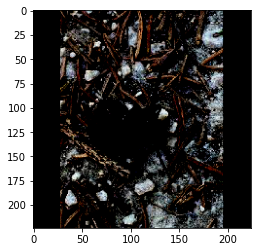

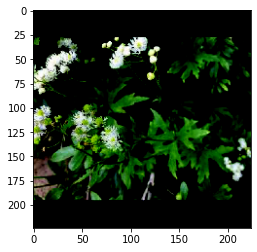

In [ ]:
import matplotlib.pyplot as plt
image, label = next(iter(l_train_dataloader))   
print(image.size(), label)
plt.figure(0)
plt.imshow(image[0].permute(1, 2, 0))
image, name = next(iter(test_dataloader))
print(image.size(), name)
plt.figure(1)
plt.imshow(image[0].permute(1, 2, 0))

Figure out the minimum image size

In [ ]:
import torch
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

l_train_path = './l_train'
u_train_path = './u_train'
val_path = './val'
test_path = './test'
classes = 810


l_train = os.path.join(l_train_path, 'l_train')

val = os.path.join(val_path, 'val')

u_train = os.path.join(u_train_path, 'u_train')

test = os.path.join(test_path, 'test')



Train

124 (124, 300)


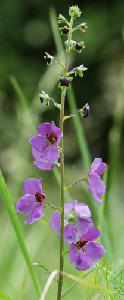

84 (300, 84)


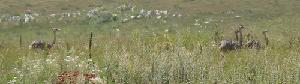

25200 (300, 84)


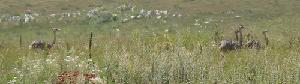

In [ ]:
min_x = 9999
min_y = 9999
min_total = 999999999
min_x_img = None
min_y_img = None
min_total_img = None
for i in range(classes):
    path = os.path.join(l_train, str(i))
    images = os.listdir(path)
    for j in range(len(images)):
      file = os.path.join(path, images[j])
      image = Image.open(file)
      x = image.size[0]
      y = image.size[1]
      total = x*y
      if x < min_x:
        min_x = x
        min_x_img = image
      if y < min_y:
        min_y = y
        min_y_img = image
      if total < min_total:
        min_total = total
        min_total_img = image
print(min_x, min_x_img.size)
display(min_x_img)
print(min_y, min_y_img.size)
display(min_y_img)
print(min_total, min_total_img.size)
display(min_total_img)

Val

117 (117, 300)


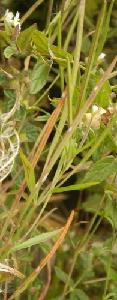

99 (300, 99)


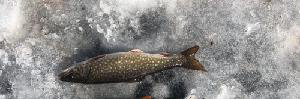

29700 (300, 99)


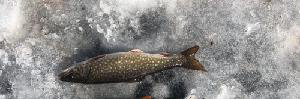

In [ ]:
min_x = 9999
min_y = 9999
min_total = 999999999
min_x_img = None
min_y_img = None
min_total_img = None
for i in range(classes):
    path = os.path.join(val, str(i))
    images = os.listdir(path)
    for j in range(len(images)):
      file = os.path.join(path, images[j])
      image = Image.open(file)
      x = image.size[0]
      y = image.size[1]
      total = x*y
      if x < min_x:
        min_x = x
        min_x_img = image
      if y < min_y:
        min_y = y
        min_y_img = image
      if total < min_total:
        min_total = total
        min_total_img = image
print(min_x, min_x_img.size)
display(min_x_img)
print(min_y, min_y_img.size)
display(min_y_img)
print(min_total, min_total_img.size)
display(min_total_img)

Unlabeled

50 (50, 300)


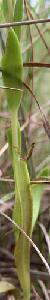

41 (300, 41)


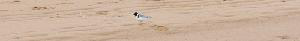

12300 (300, 41)


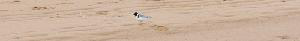

In [ ]:
min_x = 9999
min_y = 9999
min_total = 999999999
min_x_img = None
min_y_img = None
min_total_img = None


images = os.listdir(u_train)
for j in range(len(images)):
  file = os.path.join(u_train, images[j])
  image = Image.open(file)
  x = image.size[0]
  y = image.size[1]
  total = x*y
  if x < min_x:
    min_x = x
    min_x_img = image
  if y < min_y:
    min_y = y
    min_y_img = image
  if total < min_total:
    min_total = total
    min_total_img = image
print(min_x, min_x_img.size)
display(min_x_img)
print(min_y, min_y_img.size)
display(min_y_img)
print(min_total, min_total_img.size)
display(min_total_img)

Test

66 (66, 300)


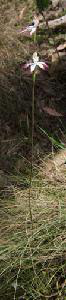

81 (300, 81)


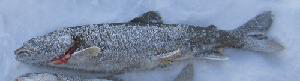

19800 (66, 300)


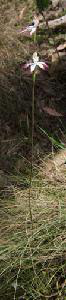

In [ ]:
min_x = 9999
min_y = 9999
min_total = 999999999
min_x_img = None
min_y_img = None
min_total_img = None


images = os.listdir(test)
for j in range(len(images)):
  file = os.path.join(test, images[j])
  image = Image.open(file)
  x = image.size[0]
  y = image.size[1]
  total = x*y
  if x < min_x:
    min_x = x
    min_x_img = image
  if y < min_y:
    min_y = y
    min_y_img = image
  if total < min_total:
    min_total = total
    min_total_img = image
print(min_x, min_x_img.size)
display(min_x_img)
print(min_y, min_y_img.size)
display(min_y_img)
print(min_total, min_total_img.size)
display(min_total_img)